In [207]:
import numpy as np
import pandas as pd 
import hvplot as hv
import hvplot.pandas
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error

from src.util.model import eval_model
seed = 42

In [35]:
dff0 = pd.DataFrame()
dff1 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    if fn.split(".")[0][-1] == "1":
        dff1 = pd.concat([dff1, df])
    else:
        dff0 = pd.concat([dff0, df])
print(dff0.shape)
print(dff1.shape)

dff0['timestamp'] = pd.to_datetime(dff0['timestamp'])
dff1['timestamp'] = pd.to_datetime(dff1['timestamp'])

snow_2020-2025_p160_fxx1.csv (35016, 68)
snow_2020-2025_p160_fxx0.csv (35016, 68)
snow_2020-2025_p159_fxx0.csv (29184, 68)
snow_2020-2025_p159_fxx1.csv (35016, 68)
(64200, 68)
(70032, 68)


In [36]:
dff0 = dff0.loc[:, ~(dff0 == -999).all()]
dff1 = dff1.loc[:, ~(dff1 == -999).all()]

In [193]:
daily_avg = dff0.groupby(pd.Grouper(key='timestamp', freq='D')).mean()
daily_avg.replace(-999, 0, inplace=True)
print(daily_avg.head().to_markdown())

| timestamp           |        Qs |       Ql |   Qg |      TSG |   Qg0 |     Qr |   dIntEnergySnow |   meltFreezeEnergySnow |   ColdContentSnow |    OLWR |    ILWR |   LWR_net |    OSWR |    ISWR |      Qw |   pAlbedo |   mAlbedo |   ISWR_h |   ISWR_dir |   ISWR_diff |      TA |   TSS_mod |   T_bottom |      RH |      VW |   VW_drift |   MS_Snow |   HS_mod |   HS_meas |   hoar_size |   wind_trans24 |   HN3 |   HN6 |   HN12 |   HN24 |   HN72_24 |   PSUM24 |   ski_pen |   SWE |   MS_Water |   MS_Water_Soil |   MS_Ice_Soil |   MS_Wind |   MS_Rain |   MS_SN_Runoff |   MS_Surface_Mass_Flux |   MS_Sublimation |   MS_Evap |   Sclass1 |   Sclass2 |   zSd |   Sd |   zSn |   Sn |   zSs |   Ss |   zS4 |   S4 |   zS5 |   S5 |      id |   altitude |   slope_angle |   slope_azi |
|:--------------------|----------:|---------:|-----:|---------:|------:|-------:|-----------------:|-----------------------:|------------------:|--------:|--------:|----------:|--------:|--------:|--------:|----------:|----

In [194]:
# os.listdir("../../../data/FACFAC_Danger_rating_zone_elv.csv")
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['forecast_zone_id'] == "whitefish"]
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels[['date','lower']]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

(802, 2)
         date  lower
20 2020-10-19      0
21 2020-10-20      0
22 2020-10-21      0
23 2020-10-22      0
24 2020-10-23      0


In [195]:
y_dates = danger_levels['date'].to_list()

avgs = daily_avg.reset_index()

avgs = avgs[avgs['timestamp'].isin(danger_levels['date'])]
avgs.rename(columns={"timestamp":"date"}, inplace=True)

data = pd.merge(avgs, danger_levels, on='date', how='outer')
data.rename(columns={"lower":"danger_level"}, inplace=True)

def change_dangers(danger):
    if danger >= 3:
        return 3
    return danger

data['danger_level'] = data['danger_level'].apply(change_dangers)

exclude = ['date','id', 'slope_azi', 'danger_level']
X = data[[c for c in data.columns if c not in exclude]]
y = data['danger_level']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [220]:
dtree = DecisionTreeClassifier(random_state=seed, max_depth=5,min_samples_leaf=5)
dtree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Train
Accuracy 0.78
MSE: 0.27629233511586454
RMSE: 0.5256351730200943
MAE: 0.24064171122994651
Test
Accuracy 0.69
MSE: 0.4066390041493776
RMSE: 0.6376825261439877
MAE: 0.34024896265560167


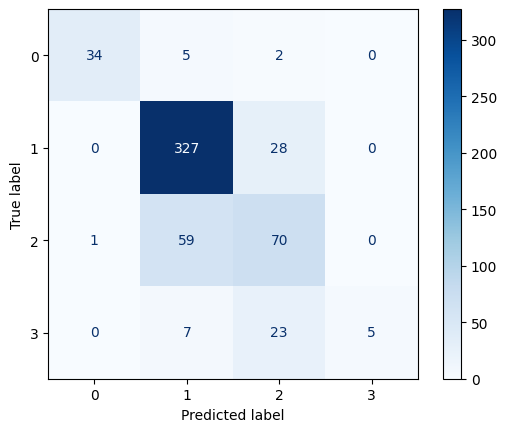

In [221]:
y_pred = dtree.predict(X_test)

print("Train")
eval_model(y_train, dtree.predict(X_train), plot=True)

print("Test")
eval_model(y_test, y_pred)

In [238]:
y_train_proba = dtree.predict_proba(X_train)
y_train_pred = np.argmax(y_train_proba, axis=1)
train_acc = eval_model(y_train, y_train_pred)

y_train_proba = dtree.predict_proba(X_test)
y_train_pred = np.argmax(y_train_proba, axis=1)
train_acc = eval_model(y_test, y_train_pred)


Accuracy 0.78
MSE: 0.27629233511586454
RMSE: 0.5256351730200943
MAE: 0.24064171122994651
Accuracy 0.69
MSE: 0.4066390041493776
RMSE: 0.6376825261439877
MAE: 0.34024896265560167


In [236]:
feature_importances = pd.DataFrame(dtree.feature_importances_,index = X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=False)

print(feature_importances[feature_importances['importance'] > 0])

           importance
altitude     0.258143
ILWR         0.111234
Sclass2      0.074162
SWE          0.068196
S5           0.066874
ISWR_diff    0.065222
Sd           0.057047
S4           0.051517
hoar_size    0.050065
TSG          0.047221
zS4          0.043399
HN72_24      0.039639
MS_Water     0.039284
Ql           0.012819
zSs          0.008584
HN24         0.005025
Qs           0.001570


[Text(0.5722222222222222, 0.9166666666666666, 'x[39] <= 0.831\ngini = 0.537\nsamples = 561\nvalue = [41, 355, 130, 35]'),
 Text(0.2833333333333333, 0.75, 'x[36] <= 0.406\ngini = 0.464\nsamples = 425\nvalue = [28.0, 298.0, 83.0, 16.0]'),
 Text(0.42777777777777776, 0.8333333333333333, 'True  '),
 Text(0.12222222222222222, 0.5833333333333334, 'x[15] <= 0.539\ngini = 0.41\nsamples = 304\nvalue = [18, 227, 51, 8]'),
 Text(0.06666666666666667, 0.4166666666666667, 'x[1] <= 68.185\ngini = 0.554\nsamples = 138\nvalue = [17, 85, 31, 5]'),
 Text(0.044444444444444446, 0.25, 'x[8] <= -0.057\ngini = 0.512\nsamples = 130\nvalue = [13, 85, 29, 3]'),
 Text(0.022222222222222223, 0.08333333333333333, 'gini = 0.678\nsamples = 11\nvalue = [5, 2, 3, 1]'),
 Text(0.06666666666666667, 0.08333333333333333, 'gini = 0.461\nsamples = 119\nvalue = [8, 83, 26, 2]'),
 Text(0.08888888888888889, 0.25, 'gini = 0.625\nsamples = 8\nvalue = [4, 0, 2, 2]'),
 Text(0.17777777777777778, 0.4166666666666667, 'x[22] <= -12.974\ng

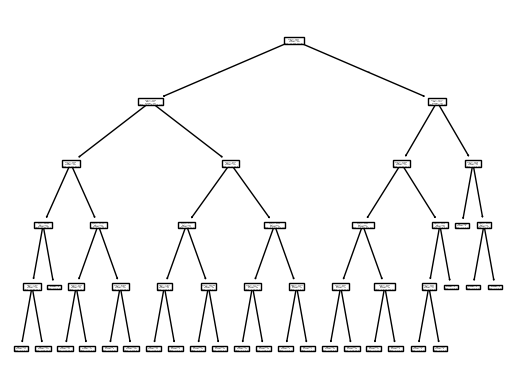

In [219]:
plot_tree(dtree)